# Bayesian Statistics: Assignment 2
Yizhen Dai, S2395479

## Introduction
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew[1]. This sensational tragedy shocked the international community and led to better safety regulations for ships. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this assignment, we will build a Bayesian logistic regression classifier to predict the passenger survial. 

## Get the data ready

In [0]:
!pip install arviz

In [0]:
### import packages
import numpy as np
import pandas as pd

import pystan 
import arviz

import scipy
from scipy.stats import bernoulli

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split




Splitting data before EDA and pre-processing to avoid data leakge

In [192]:
### Read the data
FILE = '/content/titanic.csv'
data = pd.read_csv(FILE)

### 'PassengerID','Name'and'Ticket'are irrelevant to our study, which will be excluded from our study.
data = data.drop(['PassengerId','Ticket','Name'],axis=1)

### Spllit the data
train, test = train_test_split(data, train_size=600, random_state=2020)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(data.shape[0],train.shape[0],test.shape[0]))

Total sample size = 891; training sample size = 600, testing sample size = 291


In [0]:
# Define a function to plot the surivial rate
def plot(df,group):
    ### df is the dataframe, group is the variable name
    ratio=df.groupby(group).mean()['Survived'] # Survial ratio
    ratio.plot.bar(color='pink',alpha=0.7)
    plt.title("Survival Rate by %s" % group)
    plt.xticks(rotation=0)
    plt.ylabel('Survival Rate')
    return ratio

In [194]:
### Calculate the missing value %
total_data = train.count()
percent_data=total_data/train.shape[0]
print('The missing % in the training data for variables are:')
print(percent_data)

The missing % in the training data for variables are:
Survived    1.000000
Pclass      1.000000
Sex         1.000000
Age         0.816667
SibSp       1.000000
Parch       1.000000
Fare        1.000000
Cabin       0.230000
Embarked    0.996667
dtype: float64


We can see that about 77% of recorded passengers in the training data set lack 'Cabin' data. we will test if the passengers with 'Cabin' data have the same survival rate with those that do not have 'Cabin' data. 





In [0]:
train.loc[:,'Without_Cabin']= train['Cabin'].isnull()

Without_Cabin
False    0.688406
True     0.281385
Name: Survived, dtype: float64

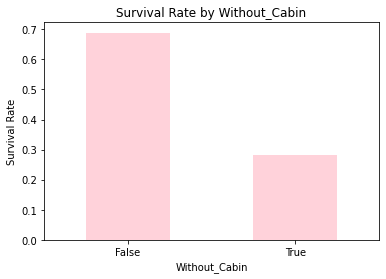

In [196]:
plot(train,"Without_Cabin")

It appears passengers without cabin information have a lower survivate rate. It may due to that it was harder to gather the cabin information of people who did not survive the trip. We will use the variable 'Without_Cabin' instead of 'Cabin', i.e.  we will replace the 'Cabin' column with a new column showing if there is cabin information for the passenger.

In [0]:
train = train.drop(['Cabin'],axis=1)
### apply the same rule to test data
test.loc[:,'Without_Cabin']= test['Cabin'].isnull()
test = test.drop(['Cabin'],axis=1)

It is also shown less than 0.004 of passengers in the training data set miss 'Embarked' information. 

In [198]:
train.Embarked.value_counts()

S    434
C    115
Q     49
Name: Embarked, dtype: int64

We will fill the missing 'Embarked' values in train and test data with mode in train data: 'S'

In [0]:
# Replace nan values for both train and test data
train['Embarked'].fillna('S', inplace=True)
test['Embarked'].fillna('S', inplace=True)

Also, about 19% of age data are missing. Next, we will test if the passengers with age data have the same survival rate with those that do not have age data. It will help us to decide how we handle the missing age data.

Without_Age
False    0.397959
True     0.272727
Name: Survived, dtype: float64

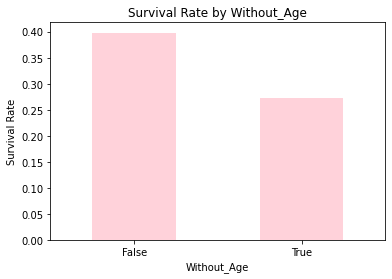

In [200]:
# Test if the passengers with age data have the same survival rate with those that do not have age data.
train.loc[:,'Without_Age']= np.isnan(train['Age'])
plot(train,"Without_Age")

It appears passengers without age information have a lower survivate rate. It may due to that it was harder to gather the age information of people who did not survive the trip. The Nan values are replaced with the mean age of the same SEX and PClass group.

In [0]:
### Replace nan values use mean values
train.loc[:,'Age'] = train.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
### Apply the same rule to test data
test.loc[:,'Without_Age']= np.isnan(test['Age'])
test.loc[:,'Age'] = test.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

**In summary**



*   'PassengerId','Ticket','Name','Cabin' are removed
*   'Without_Cabin' and 'Without_Age' are added
*   Missing values in 'Embarked' is replaced with the mode 'S'
*   Missing values in 'Age' is replaced with the mean age of the same SEX and PClass group.





## Check Variabless
We will compare the survival rates between the groups in each variable. It will give us insights if they are useful in prediction.

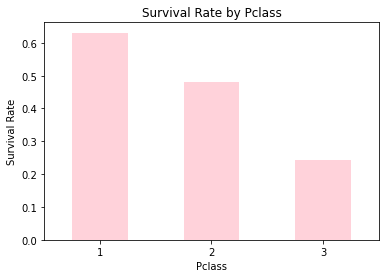

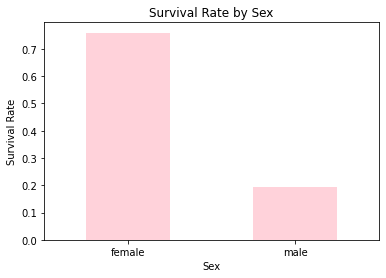

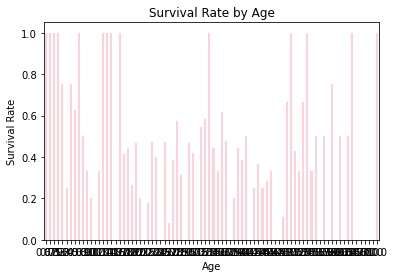

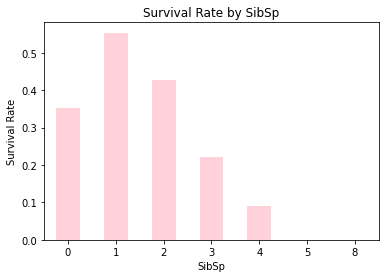

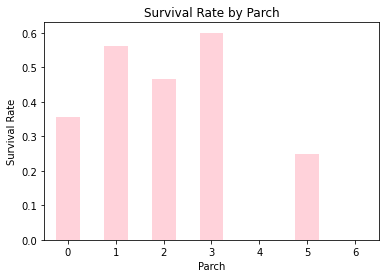

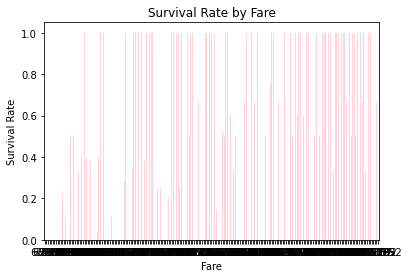

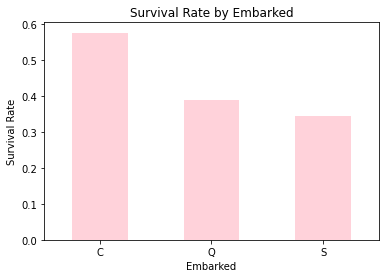

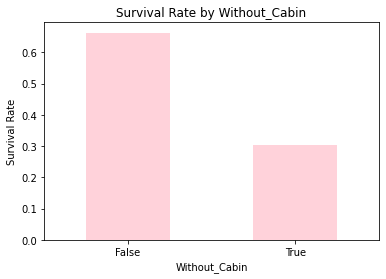

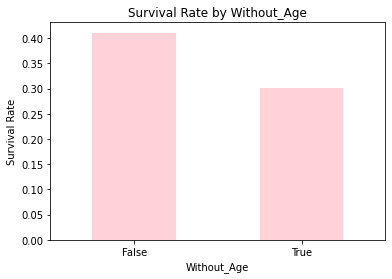

In [65]:
i = 0
for col in train.columns:
    i+=1
    if col != 'Survived':
        plt.figure(i)
        plot(train, col)

We can see the survival rate differs between groups for each variables. We will include them in our model.

In summary, the variables we are going to use are 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Without_Cabin', 'Without_Age'.


In [0]:
### seperate X and y
ytrain = train['Survived']
Xtrain = train.drop(['Survived'],axis=1)

ytest = test['Survived']
Xtest = test.drop(['Survived'],axis=1)

### coding variables so they are numeric
Xtrain["Sex"] = Xtrain["Sex"].astype("category")
Xtrain["Sex"].cat.categories = [0,1]
Xtrain["Sex"] = Xtrain["Sex"].astype("int")

Xtrain["EmbarkedC"] = (Xtrain["Embarked"] == 'C').astype("int")
Xtrain["EmbarkedQ"] = (Xtrain["Embarked"] == 'Q').astype("int")
Xtrain["EmbarkedS"] = (Xtrain["Embarked"] == 'S').astype("int")
Xtrain = Xtrain.drop(['Embarked'],axis=1)

Xtrain["Without_Age"] = Xtrain["Without_Age"].astype("category")
Xtrain["Without_Age"].cat.categories = [0,1]
Xtrain["Without_Age"] = Xtrain["Without_Age"].astype("int")

Xtrain["Without_Cabin"] = Xtrain["Without_Cabin"].astype("category")
Xtrain["Without_Cabin"].cat.categories = [0,1]
Xtrain["Without_Cabin"] = Xtrain["Without_Cabin"].astype("int")

Xtest["Sex"] = Xtest["Sex"].astype("category")
Xtest["Sex"].cat.categories = [0,1]
Xtest["Sex"] = Xtest["Sex"].astype("int")

Xtest["EmbarkedC"] = (Xtest["Embarked"] == 'C').astype("int")
Xtest["EmbarkedQ"] = (Xtest["Embarked"] == 'Q').astype("int")
Xtest["EmbarkedS"] = (Xtest["Embarked"] == 'S').astype("int")
Xtest = Xtest.drop(['Embarked'],axis=1)

Xtest["Without_Age"] = Xtest["Without_Age"].astype("category")
Xtest["Without_Age"].cat.categories = [0,1]
Xtest["Without_Age"] = Xtest["Without_Age"].astype("int")

Xtest["Without_Cabin"] = Xtest["Without_Cabin"].astype("category")
Xtest["Without_Cabin"].cat.categories = [0,1]
Xtest["Without_Cabin"] = Xtest["Without_Cabin"].astype("int")

Now everything is numerically encoded and there are no missing values


# Bayesian Logistic Regression

We are going to use Hamiltonian Monte Carlo method for Bayesian Logistic Regression, which is implemented in PyStan in python for using Stan probabilistic programming language. Hamiltonian Monte Carlo converges more quickly  than Gibbs sampling. The code roughly follows the instruction from Steve Avsec[2].

In [0]:
### Standardize the variables
means = Xtrain.loc[:, :].mean()
std = Xtrain.loc[:, :].std()
Xtrain_scaled = (Xtrain - means)/std
Xtest_scaled  = (Xtest  - means)/std

Based on Steve Avsec's suggestion[2], we will use QR decomposition of the original data matrix. The model will be more efficient by "stepping in perpendicular directions rather than in the arbitrary directions as defined by the data matrix". 

In [0]:
# Compute the QR decomposition 
q, r = np.linalg.qr(Xtrain, moe='reduced')

q = q*np.sqrt(len(Xtrain))
r = r/np.sqrt(len(Xtrain))

# Compute the inverse of R as a map for back transformation
r_inverse = np.linalg.inv(r)

In [240]:
### The code for pystan
logistic_code = """
data {            // define the input data
  int<lower=0> N; // number of train objects
  int<lower=0> K; // number of variable
  int<lower=0> N2;// number of test objects   
  matrix[N,K] Q;  // Q from QR decomposition 
  matrix[K,K] R;  // R from QR decomposition 
  matrix[K,K] R_inverse;
  matrix[N2,K] new_X; //the matrix for the test data
  int y[N];        // the response
}
transformed data {}
parameters {        //introduce the parameters
    real alpha;     // intercept
    vector[K] theta;// coefficients on Q_ast
}
transformed parameters {}
model {             // specify the model
    y ~ bernoulli_logit(Q * theta + alpha);
}
generated quantities {
    vector[K] beta;  
    vector[N2] y_pred;  
    beta = R_inverse * theta; // coefficients on X
    y_pred = alpha + new_X * beta;
}
"""

sm = pystan.StanModel(model_code=logistic_code, model_name='LR')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL LR_de8a79052486f4f0d9f374377c2b9113 NOW.


In [0]:
# start the sampling
fit = sm.sampling(data=logistic_dat, chains=4, iter=3000, warmup=1000)

## Assessment of Convergence
Arviz library is used to assess the convergence of the MCMC method. 

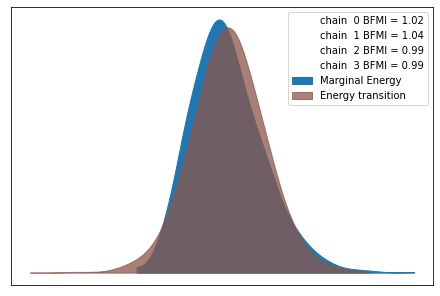

In [256]:
### draw the energy plot
inf_data = arviz.convert_to_inference_data(fit)
arviz.plot_energy(inf_data)

We can see the BFMI statistic for all chians are larger than 0.3. indicating good convergence.

## Inference
First, we will set up a naive classifier. This is the baseline for our analysis.


In [0]:
### a naive classifier as a baseline: 
# (i) All women survived.
# (ii) All men died.
naive_p = (Xtest.Sex == 0).astype(int) # female = 0, survival = 1

Calculate the prediction from the Bayesian Logistic model


In [0]:
### Bayesian Logistic prediction
ex = fit.extract()                                                                      
target = np.mean(ex['y_pred'], axis=0) 
bayes_p = scipy.special.expit(target) # prob
bayes_y = np.floor(bayes_p * 2) # survial

0-1 Loss and sensitivity/specificity:


*   0-1 Loss is the percentage of wrongly identified items
*   Sensitivity = True Positives / (True Positives + False Negatives)
*   Specificity = True Negatives / (True Negatives + False Positives)




In [274]:
# 0-1 Loss
bayes_loss = mean(bayes_y != ytest)
naive_loss = mean(naive_p != ytest)
print('0-1 Loss for Naive Classifier: %.3f' % naive_loss)
print('0-1 Loss for Bayesian Logistic: %.3f' % bayes_loss)

0-1 Loss for Naive Classifier: 0.241
0-1 Loss for Bayesian Logistic: 0.216


We can see the Bayesian Logistic Regression model has a lower 0-1 loss compared to the naive classifer. The 0-1 Loss droped by 0.025.

In [281]:
### sensitivity/specificity
# Naive
tp = sum(np.array(naive_p == ytest) & np.array(ytest == 1))
tn = sum(np.array(naive_p == ytest) & np.array(ytest == 0))

fp = sum(np.array(naive_p != ytest) & np.array(ytest == 0))
fn = sum(np.array(naive_p != ytest) & np.array(ytest == 1))

print('Sensitivity for Naive Classifier: %.3f' % (tp/(tp+fn)))
print('Specificity for Naive Classifier: %.3f' % (tn/(tn+fp)))

# Bayesian
tp = sum(np.array(bayes_y == ytest) & np.array(ytest == 1))
tn = sum(np.array(bayes_y == ytest) & np.array(ytest == 0))

fp = sum(np.array(bayes_y != ytest) & np.array(ytest == 0))
fn = sum(np.array(bayes_y != ytest) & np.array(ytest == 1))

print('Sensitivity for Bayes Logistic: %.3f' % (tp/(tp+fn)))
print('Specificity for Bayes Logistic: %.3f' % (tn/(tn+fp)))

Sensitivity for Naive Classifier: 0.650
Specificity for Naive Classifier: 0.833
Sensitivity for Bayes Logistic: 0.675
Specificity for Bayes Logistic: 0.856


We can see the Bayesian Logistic Regression model outperforms the naive classifer in both Sensitivity  and Specificity.

## ROC AUC
ROC (Receiver Operating Characteristics) curve is great tool to check or visualize the performance of classification problem. The curve is plotted with True Positive Rate (=Sensitivity) against the False Positive Rate (=1-Specificity).[3]

The code for drawing RPC and calculating AUC (Area Under The Curve) rough follows the post from Jason Brownlee[4].

Classifier: ROC AUC=0.741
Bayesian Logistic: ROC AUC=0.833


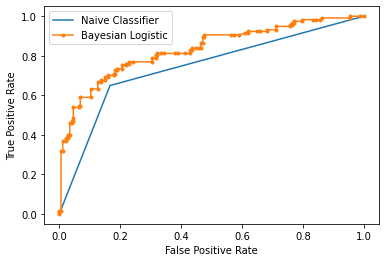

In [282]:
#### calculate ROC AUC
naive_auc = roc_auc_score(ytest, naive_p)
bayes_auc = roc_auc_score(ytest, bayes_p)
# summarize 
print('Classifier: ROC AUC=%.3f' % (naive_auc))
print('Bayesian Logistic: ROC AUC=%.3f' % (bayes_auc))

#### plot the roc curve
n_fpr, n_tpr, _ = roc_curve(ytest, naive_p)
b_fpr, b_tpr, _ = roc_curve(ytest, bayes_p)
plt.plot(n_fpr, n_tpr, linestyle='-', label='Naive Classifier')
plt.plot(b_fpr, b_tpr, marker='.', label='Bayesian Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

ROC for Bayesian Logistic model is above the Naive Classifier. AUC is 0.833 for Bayesian Logistic model and 0.741 for the Naive Classifier. It means our Bayesian Logistic model has better separability and is more capable of predicting survival.

# Reference


1.    [Titanic Data Information](https://www.kaggle.com/c/titanic/overview)
2.  [An Introduction to Bayesian Modeling in PyStan](https://opendatagroup.github.io/data%20science/2019/01/24/introduction-to-bayesian-modeling.html)
3. [Understanding AUC - ROC Curve
](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
4. [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)


